# L4-A - Building your own Quantizer: Custom Build an 8-Bit Quantizer

    In this lesson, you will learn how to compress any model in 8-bit precision.
    This quantizer is model agnostic meaning you can apply it on video , audio, texts and multimodal models

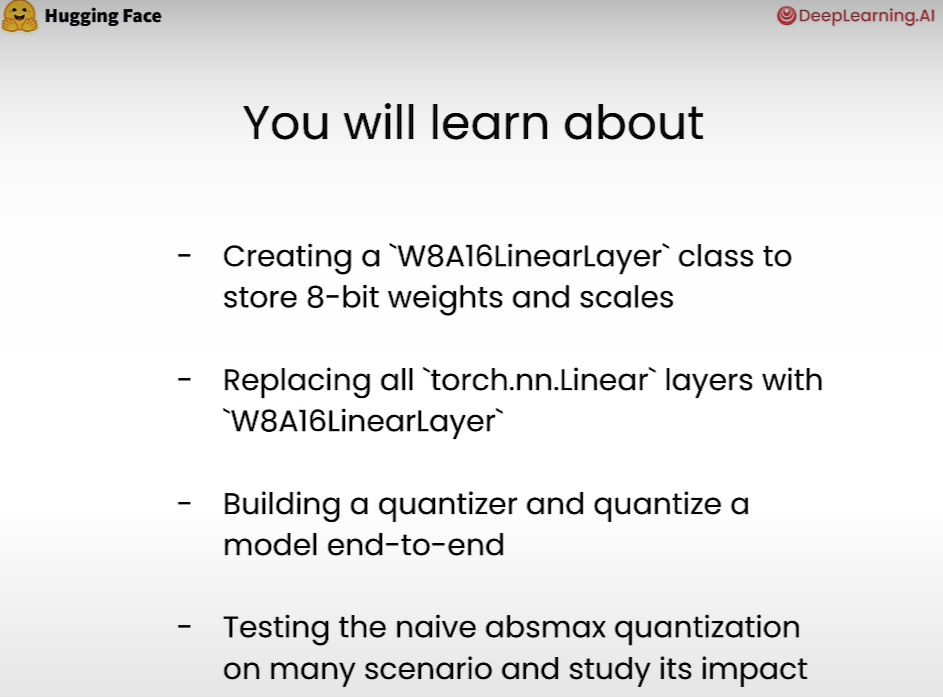

## Step 1: class `W8A16LinearLayer`

- Build the target class, `W8A16LinearLayer()`, that will be responsible for quantizing your model.
- W8 => 8 bits weights
- A16 => 16-bits activation

### 1.1 - `w8_a16_forward` Function

-
```Python
W8A16LinearLayer
                    # 8-bit  # 16-bit         # optional
* w8_a16_forward -> weights, input,   scales, bias=None
                    
```
- Cast the 8-bit `weights` to the same data type as the `input`, "casted weights",
- keeping the "casted weights" in the same range as before, [-128, 127]
- Next, $$(({inputs} \cdot \text{``casted weights''}) * {scale}) + {bias}$$ 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
random_int8 = torch.randint(-128, 127, (32, 16)).to(torch.int8)
random_hs = torch.randn((1, 16), dtype=torch.bfloat16) #hs-hidden state
scales = torch.randn((1, 32), dtype=torch.bfloat16)
bias = torch.randn((1, 32), dtype=torch.bfloat16)
# For weight matrix , when we perofrm matrix multiplication between int8 matrix and ip hidden state , 
# you will have a vector of batch size output dimension (1,32)
# scales and bias have same dimension as ooutput dimension

**Note:** Since the values are random, what you see in the video might be different than what you will get.

In [ ]:
F.linear(random_hs, random_int8.to(random_hs.dtype)) #matrix multiplication

In [ ]:
F.linear(random_hs, random_int8.to(random_hs.dtype)) * scales

In [ ]:
(F.linear(random_hs, random_int8.to(random_hs.dtype)) * scales) + bias

- Implement all this as a function, `w8_a16_forward`

In [ ]:
def w8_a16_forward(weight, input, scales, bias=None):
    
    casted_weights = weight.to(input.dtype)
    output = F.linear(input, casted_weights) * scales
    
    if bias is not None:
        output = output + bias
      
    return output

In [ ]:
print("With bias:\n\n", 
      w8_a16_forward(random_int8, random_hs, scales, bias))

print("\nWithout bias:\n\n", 
      w8_a16_forward(random_int8, random_hs, scales))

### 1.2 - `init` Function of class `W8A16LinearLayer`

- This is how the `init` is of [PyTorch Linear layer](https://pytorch.org/docs/stable/_modules/torch/nn/modules/linear.html#Linear):
```Python
def __init__(self, in_features, out_features, bias=True,
             device=None, dtype=None)

```

In [ ]:
### running this will result in an error
class W8A16LinearLayer(nn.Module):
    def __init__(self, in_features, out_features, 
                 bias=True, dtype=torch.float32):
        super().__init__()
        
        self.int8_weights = nn.Parameter(torch.Tensor([0, 1]
                                     ).to(dtype=torch.int8)) 
        # issue with this is when you create nn.parameter , pytorch expects that parameter where its able to 
        # compute gradients on it but with pytorch you can't explicitly compute gradient on int8 tensors 
        # solution => register buffer
        
try:
    
    W8A16LinearLayer(1, 1)
    
except Exception as error:
    print("\033[91m", type(error).__name__, ": ", error, "\033[0m")

In [ ]:
class W8A16LinearLayer(nn.Module):
    def __init__(self, in_features, out_features, 
                 bias=True, dtype=torch.float32):
        super().__init__()
        
        # instead of storing parameter we just store a buffer means we dont need to compute gradients on tensor & 
        # you can initialize with what type of dtype you want
        self.register_buffer(
            "int8_weights",
            torch.randint(
                -128, 127, (out_features, in_features), dtype=torch.int8
            )
        )
        
        self.register_buffer("scales", 
                             torch.randn((out_features), dtype=dtype))
        
        if bias:
            self.register_buffer("bias", 
                                 torch.randn((1, out_features), 
                                             dtype=dtype))
        
        else:
            self.bias = None

- Test your implementation.

In [ ]:
dummy_instance = W8A16LinearLayer(16, 32)

In [ ]:
print(dummy_instance.int8_weights.shape)
print(dummy_instance.scales.shape)

### 1.3 - `forward` Function of class `W8A16LinearLayer`

- Use the `w8_a16_forward` defined earlier (Step 1.1) to define the `forward` function.

In [ ]:
class W8A16LinearLayer(nn.Module):
    def __init__(self, in_features, out_features, 
                 bias=True, dtype=torch.float32):
        super().__init__()
        
        
        self.register_buffer(
            "int8_weights",
            torch.randint(
                -128, 127, (out_features, in_features), dtype=torch.int8
            )
        )
        
        self.register_buffer("scales", 
                             torch.randn((out_features), dtype=dtype))
        
        if bias:
            self.register_buffer("bias", 
                                 torch.randn((1, out_features), 
                                             dtype=dtype))
        
        else:
            self.bias = None

    def forward(self, input):
        return w8_a16_forward(self.int8_weights, 
                              input, self.scales, self.bias)

In [ ]:
module = W8A16LinearLayer(16, 32)
dummy_hidden_states = torch.randn(1, 6, 16)

In [ ]:
module(dummy_hidden_states).shape

In [ ]:
module(dummy_hidden_states).dtype

### 1.4 - `quantize` Function of class `W8A16LinearLayer`

- `quantize` function will dynamically quantize half-precision weights into `torch.int8`

In [ ]:
class W8A16LinearLayer(nn.Module):
    def __init__(self, in_features, out_features, 
                 bias=True, dtype=torch.float32):
        super().__init__()
        
        
        self.register_buffer(
            "int8_weights",
            torch.randint(
                -128, 127, (out_features, in_features), dtype=torch.int8
            )
        )
        
        self.register_buffer("scales", 
                             torch.randn((out_features), dtype=dtype))
        
        if bias:
            self.register_buffer("bias", 
                                 torch.randn((1, out_features), 
                                             dtype=dtype))
        
        else:
            self.bias = None

    def quantize(self, weights):
        w_fp32 = weights.clone().to(torch.float32) # upcasting the weights to fp32

        scales = w_fp32.abs().max(dim=-1).values / 127
        scales = scales.to(weights.dtype)

        int8_weights = torch.round(weights
                        /scales.unsqueeze(1)).to(torch.int8)

        self.int8_weights = int8_weights
        self.scales = scales
    
    def forward(self, input):
        return w8_a16_forward(self.int8_weights, 
                              input, self.scales, self.bias)

Onec we defined the quantized method , the workflow will be:
- you have base model ( in half precision - fp16/bf16)
- will loop oevr all linear layer classes 
- replace them with our new linear class and
- then call quantize by passing the old weights in order to quantize the old weights into int8

In [ ]:
module = W8A16LinearLayer(4, 8)

In [ ]:
print("Weights before:\n" , module.int8_weights)

In [ ]:
random_matrix = torch.randn((4, 8), dtype=torch.bfloat16)

In [ ]:
module.quantize(random_matrix)

In [ ]:
print("Weights After:\n" , module.int8_weights)

In [ ]:
module.scales

In [ ]:
module.scales.shape

In [ ]:
module.int8_weights.shape

In [ ]:
### dequantized weights
module.int8_weights * module.scales.unsqueeze(1)

In [ ]:
### original weights
random_matrix

In [ ]:
(random_matrix - module.int8_weights 
 * module.scales.unsqueeze(1)).abs().mean()